## Variance decomposition
Following Charlie's method: https://www.google.com/url?q=https://nbviewer.jupyter.org/github/NGEET/testbeds/blob/master/BCI_testbed/fates_output_analysis.ipynb&source=gmail&ust=1606856202560000&usg=AFQjCNHX3f_C5tYHw4PUJzjCWtVABbg4TQ

In [79]:
import os
import numpy as np
import statistics as stat
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import datetime
import seaborn as sns
import pingouin as pg

# my functions
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import YlGn_9
from funcs import fold, get_filelist, read_sims
from funcs_fig import maps, bars
from scipy import interpolate
from scipy import stats
from sklearn.linear_model import LinearRegression

### 1: Load in data

In [78]:
# 1. maizsim outputs
df_sims = pd.read_csv('/home/disk/eos8/ach315/upscale/data/sims_6105.csv', dtype={'site':'str'})

In [70]:
# 2. site & site-years
df_sites_all = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', 
                           index_col=0, dtype={'site': str})
siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_filtered.csv', 
                        dtype={'site':str}, index_col=0)
df_sites = df_sites_all[df_sites_all.site.isin(siteyears.site)]
df_sites.reset_index(inplace=True, drop=True)

In [71]:
# 3. weather
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', dtype={'site': 'str'}, index_col=0)
df_wea.reset_index(inplace=True, drop=True)

In [72]:
# 4. parameter
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_params['cvar'] = df_params.index

In [73]:
# 5. merge all
df_sims_params = pd.merge(df_sims, df_params, on='cvar')
df_sims_params_sites = pd.merge(df_sims_params, df_sites, on='site')
df_all = pd.merge(df_sims_params_sites, df_wea, on=['site','year'])
df_all.head()

year  cvar    site        date   jday  time  leaves  mature_lvs  drop_lvs  \
0  1961     0  722070  07/25/1961  22487    15    23.0          23        19   
1  1961     1  722070  08/22/1961  22515    16    16.0          16        14   
2  1961     2  722070  08/05/1961  22498    12    21.0          21        17   
3  1961     3  722070  08/08/1961  22501    21    25.0          25        20   
4  1961     4  722070  08/07/1961  22500     2    20.0          20        17   

       LA  ...       vpd  class_y         station_y  state_y  tzone_y   lat_y  \
0  306.79  ...  0.701216        1  SAVANNAH INTL AP       GA       -5  32.117   
1  158.04  ...  0.701216        1  SAVANNAH INTL AP       GA       -5  32.117   
2  193.67  ...  0.701216        1  SAVANNAH INTL AP       GA       -5  32.117   
3  343.64  ...  0.701216        1  SAVANNAH INTL AP       GA       -5  32.117   
4  324.99  ...  0.701216        1  SAVANNAH INTL AP       GA       -5  32.117   

   lon_y  years_y       area_y  perct_irri_y  
0  -81.2       22  2445.923794      6.585904  
1  -81.2       22  2445.923794      6.585904  
2  -81.2       22  2445.923794      6.585904  
3  -81.2       22  2445.923794      6.585904  
4  -81.2       22  2445.923794      6.585904  

[5 rows x 85 columns]

In [74]:
# 6. group by cvars or site
df_sims_sitemean = df_all.groupby(['site']).mean()
df_sims_cvarmean = df_all.groupby(['cvar']).mean()

### 2. Trait covariance matrix

Parameter space & correlation <br/>
All parameters are assumed to have a linear distribution and sampling was random through LHC, so in theory shouldn't display any clear patterns.

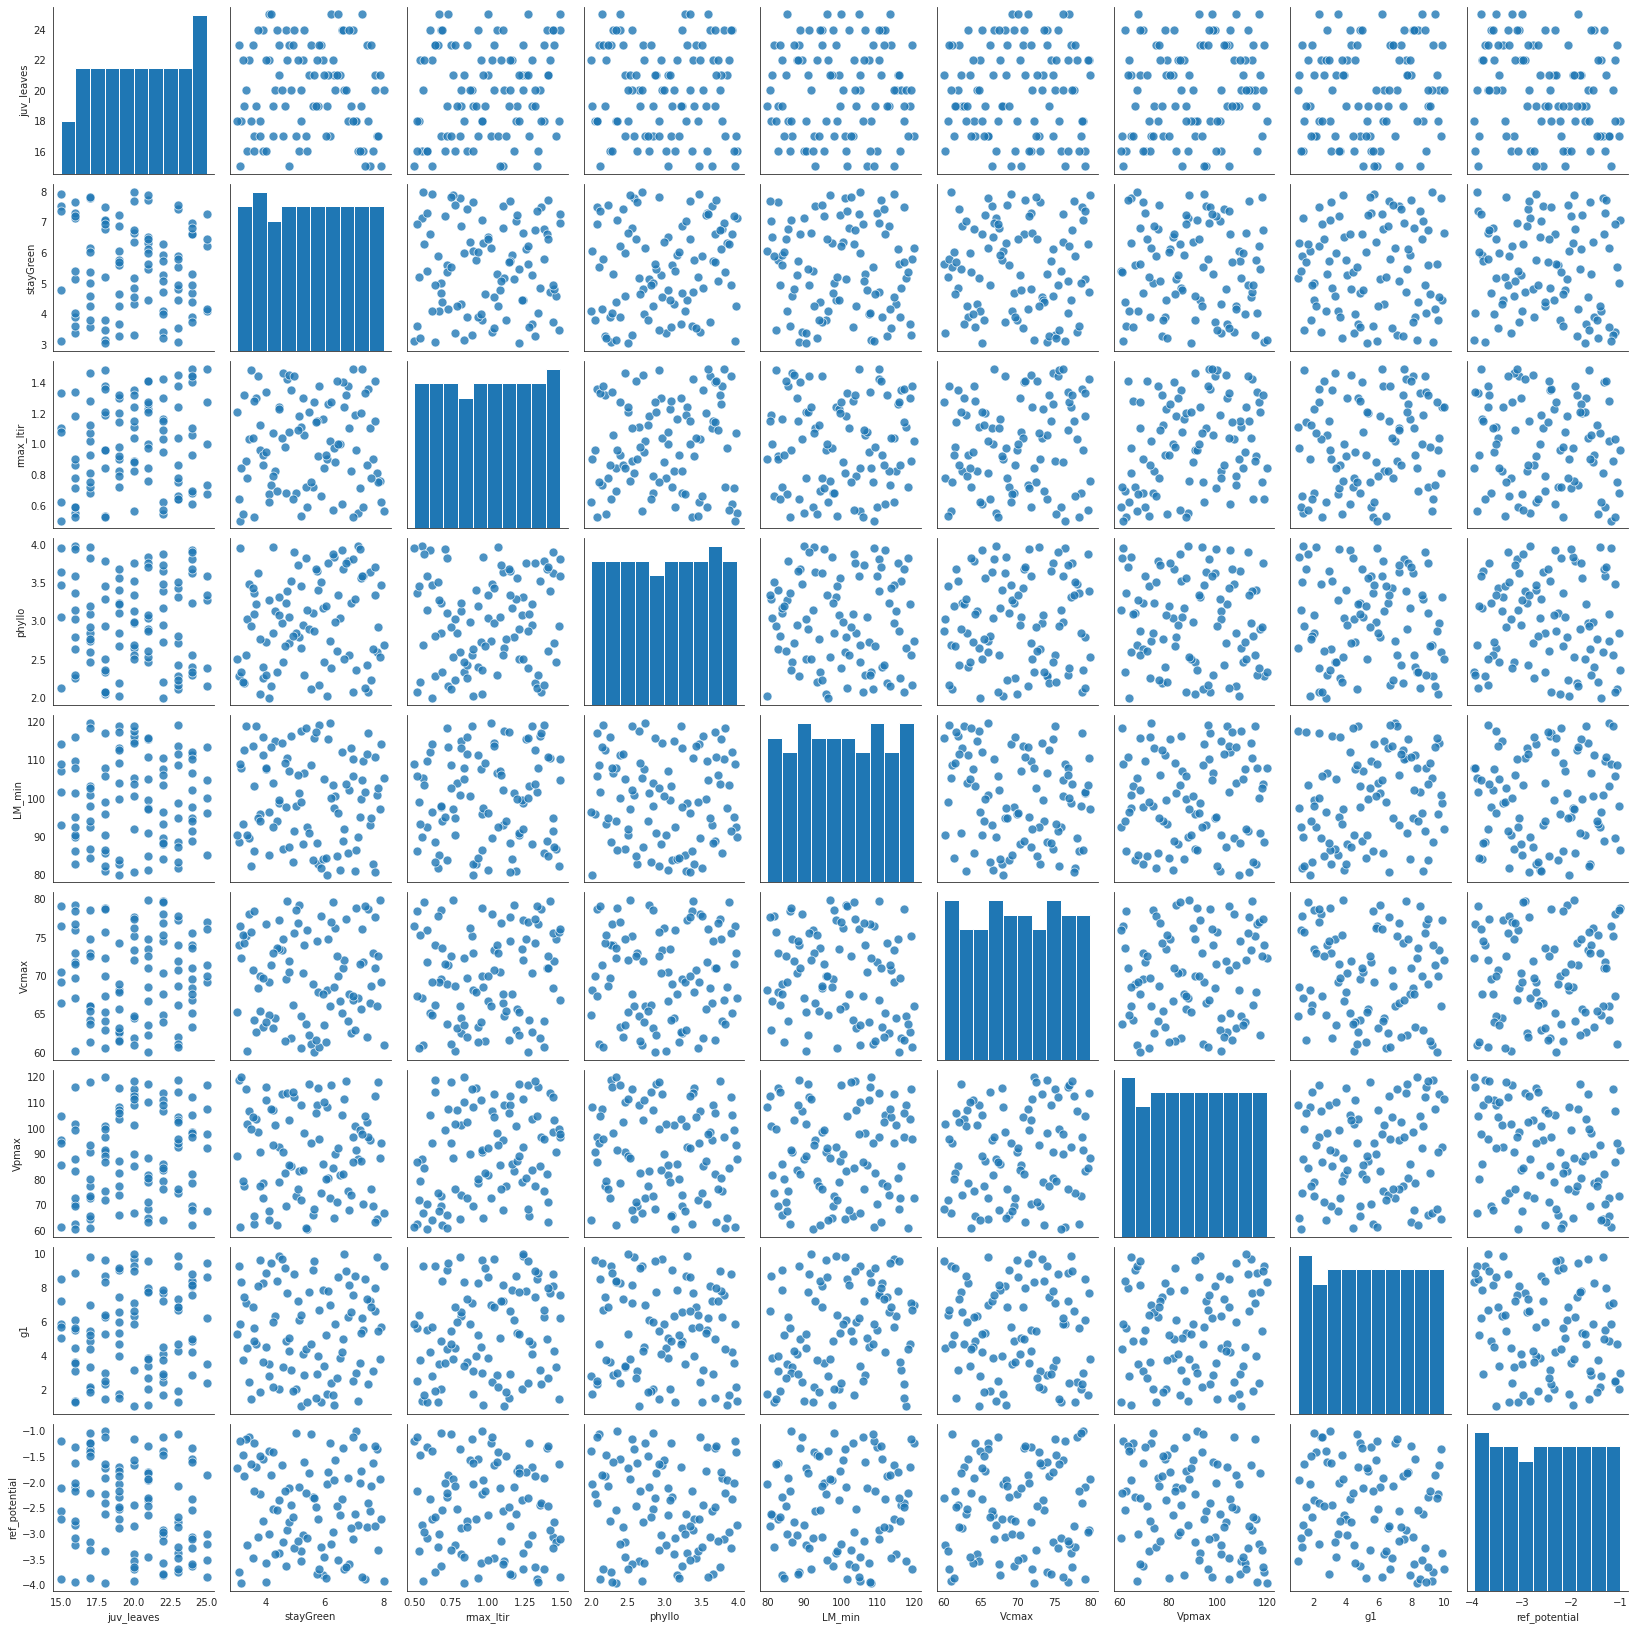

In [14]:
sns.set_style()
sns.pairplot(df_params.iloc[:,:-1], plot_kws=dict(alpha=0.8, s=80))

#### Ear biomass

In [15]:
ears = df_all.groupby('cvar').mean().dm_ear
leafarea = df_all.groupby('cvar').mean().LA
lai = df_all.groupby('cvar').mean().LAI

df_params['ear'] = pd.cut(ears, bins=np.arange(0,150,30))
df_params['leafarea'] = pd.cut(leafarea, bins=np.arange(150,800,100))
df_params['lai'] = pd.cut(lai, bins=np.arange(0.1,0.6,0.1))

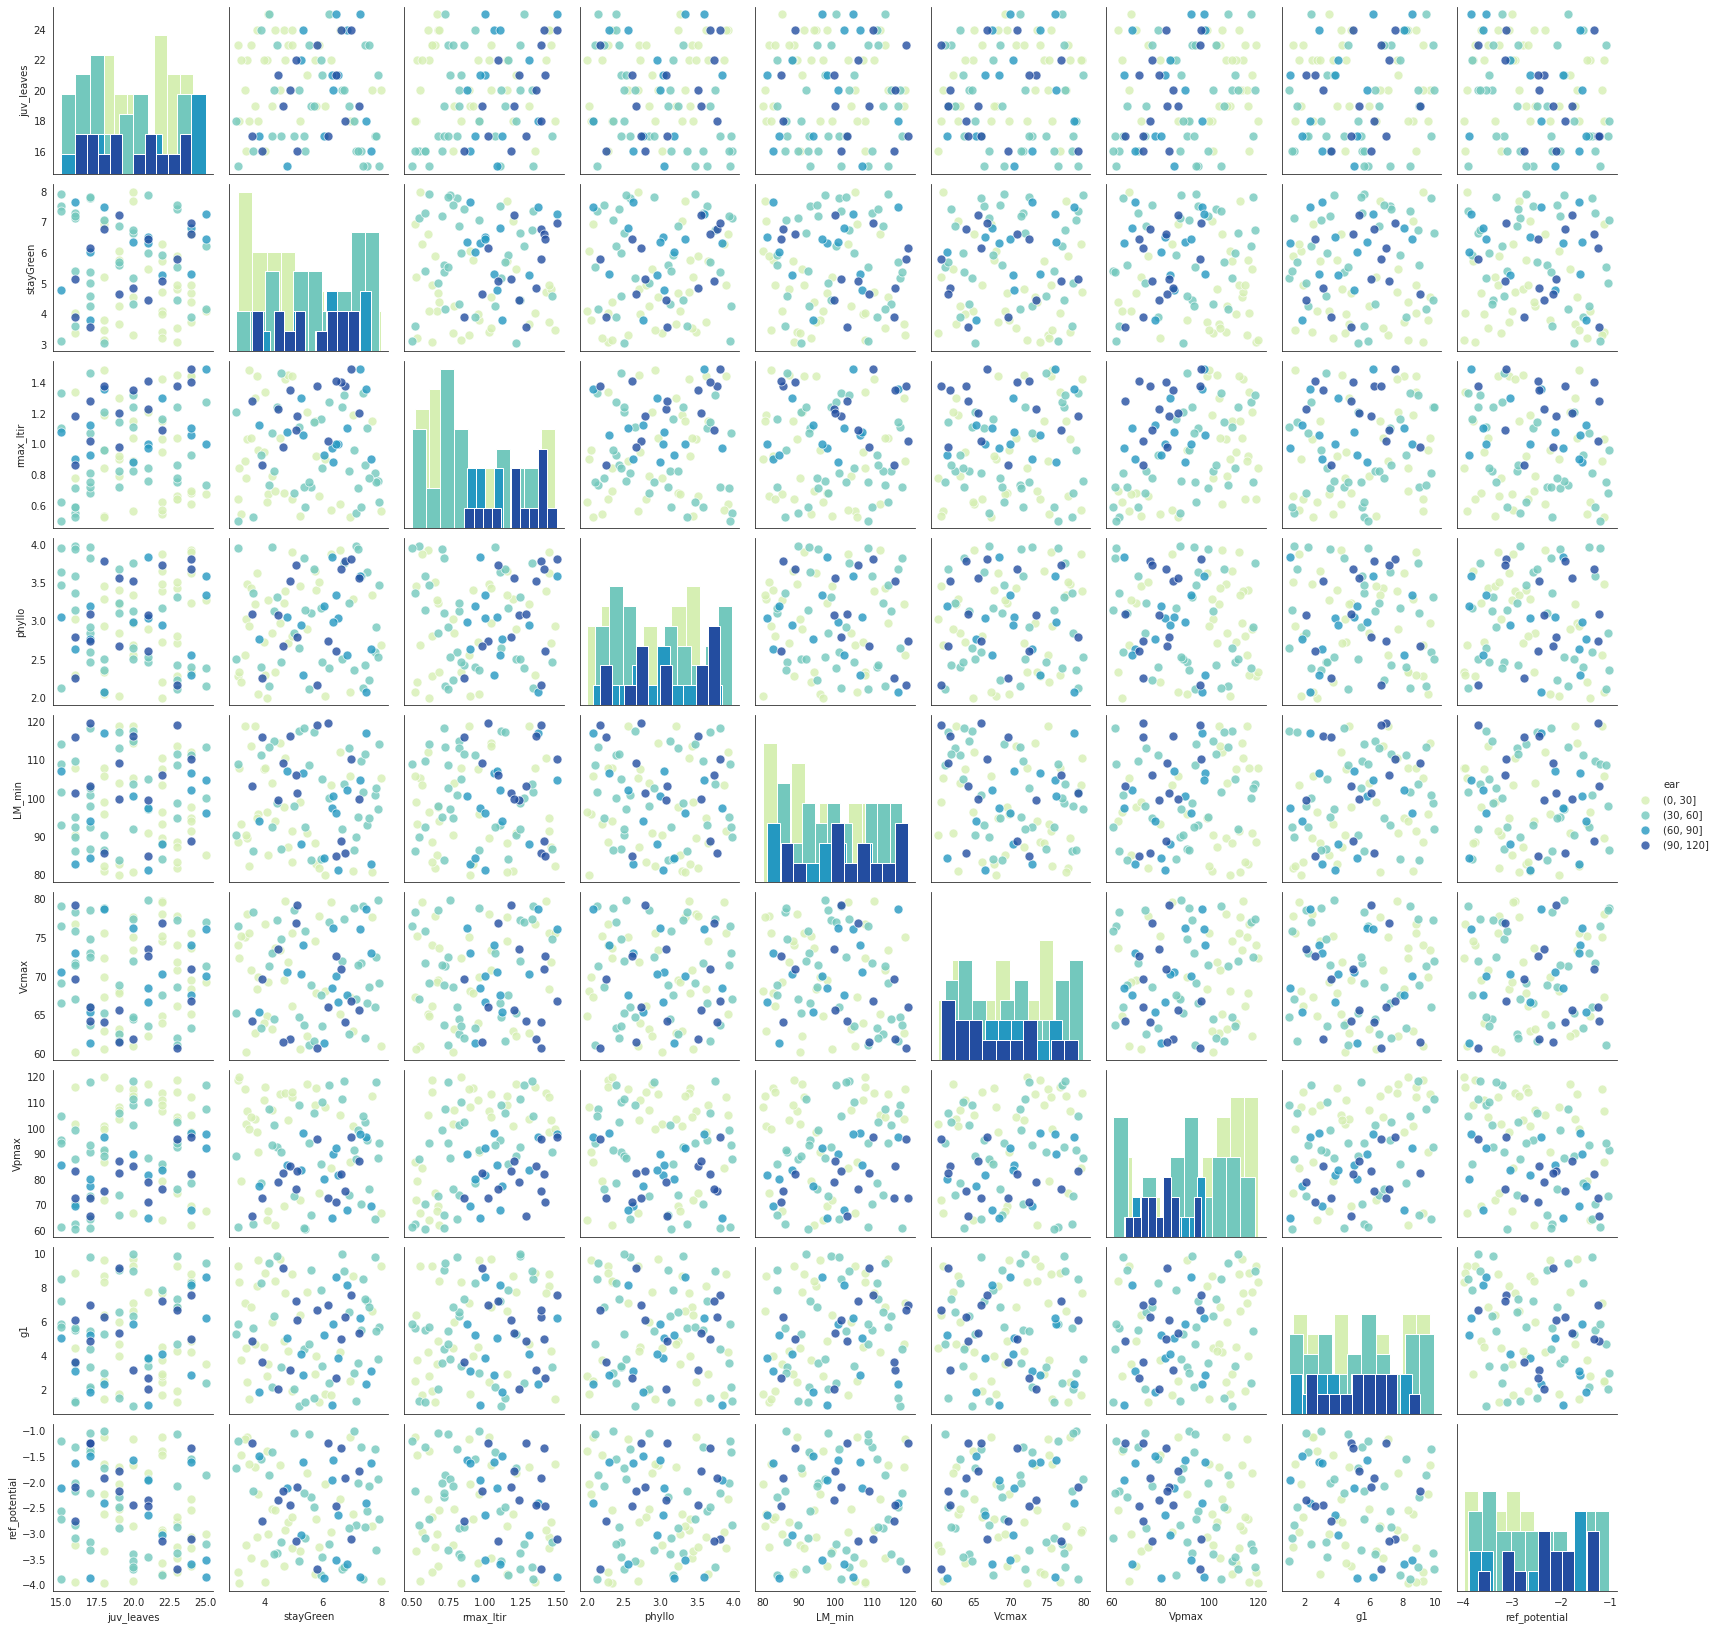

In [16]:
df_params_analyze = df_params.drop(columns=['cvar', 'leafarea', 'lai'])
sns.set_style('white')
sns.pairplot(df_params_analyze, hue='ear', palette='YlGnBu', diag_kind='hist', plot_kws=dict(alpha=0.8, s=80))

#### Total leaf area

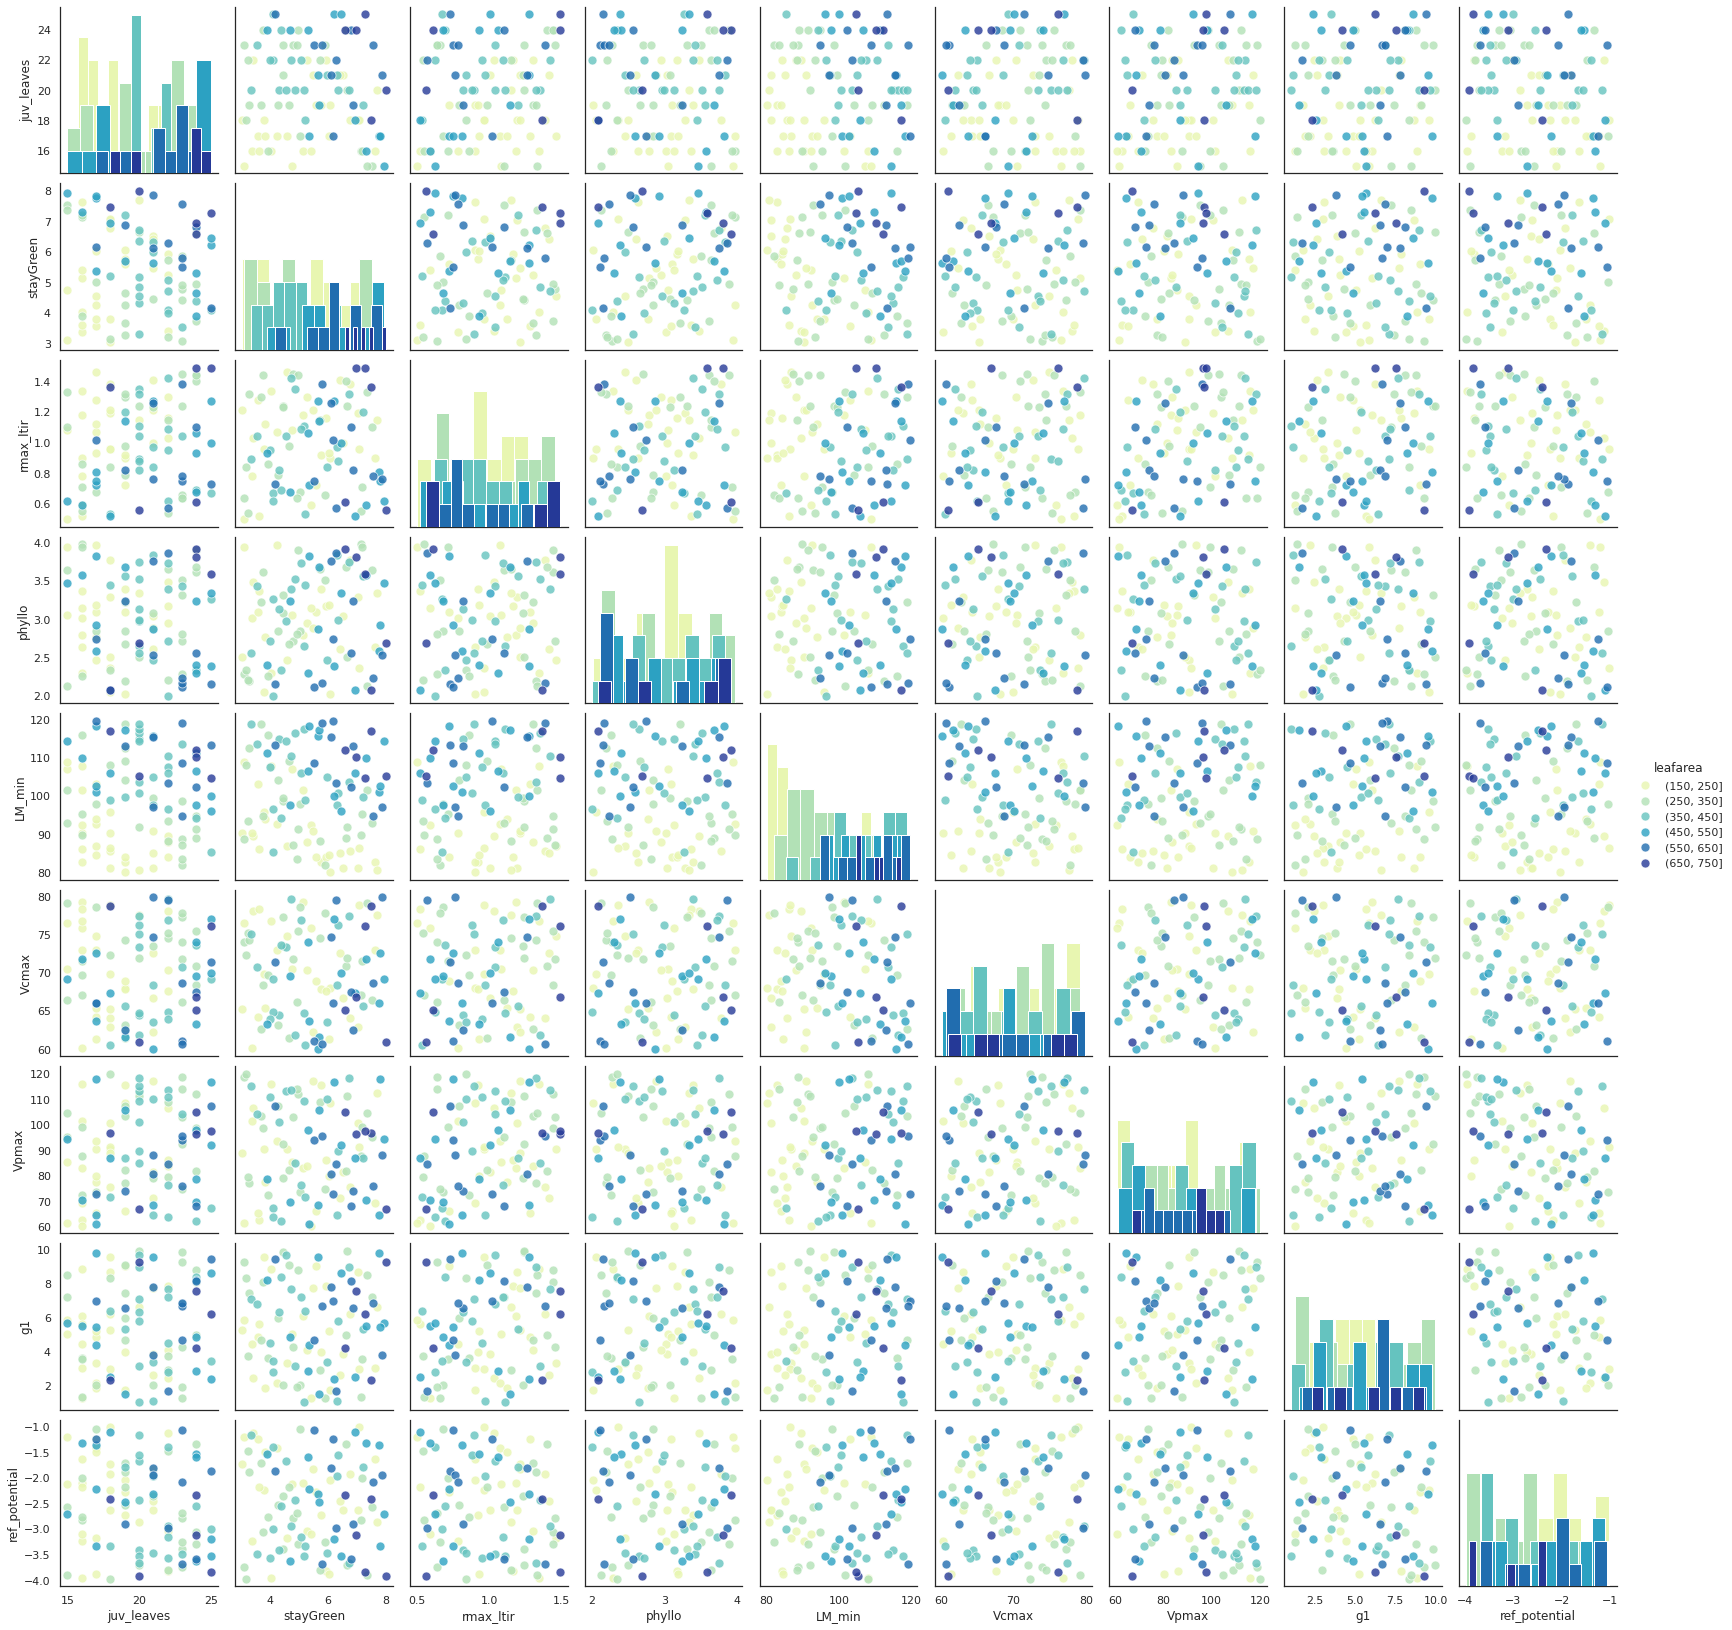

In [65]:
df_params_analyze = df_params.drop(columns=['cvar', 'ear', 'lai'])
sns.set_style('white')
sns.pairplot(df_params_analyze, hue='leafarea', palette='YlGnBu', diag_kind='hist', plot_kws=dict(alpha=0.8, s=80))

#### Leaf area index

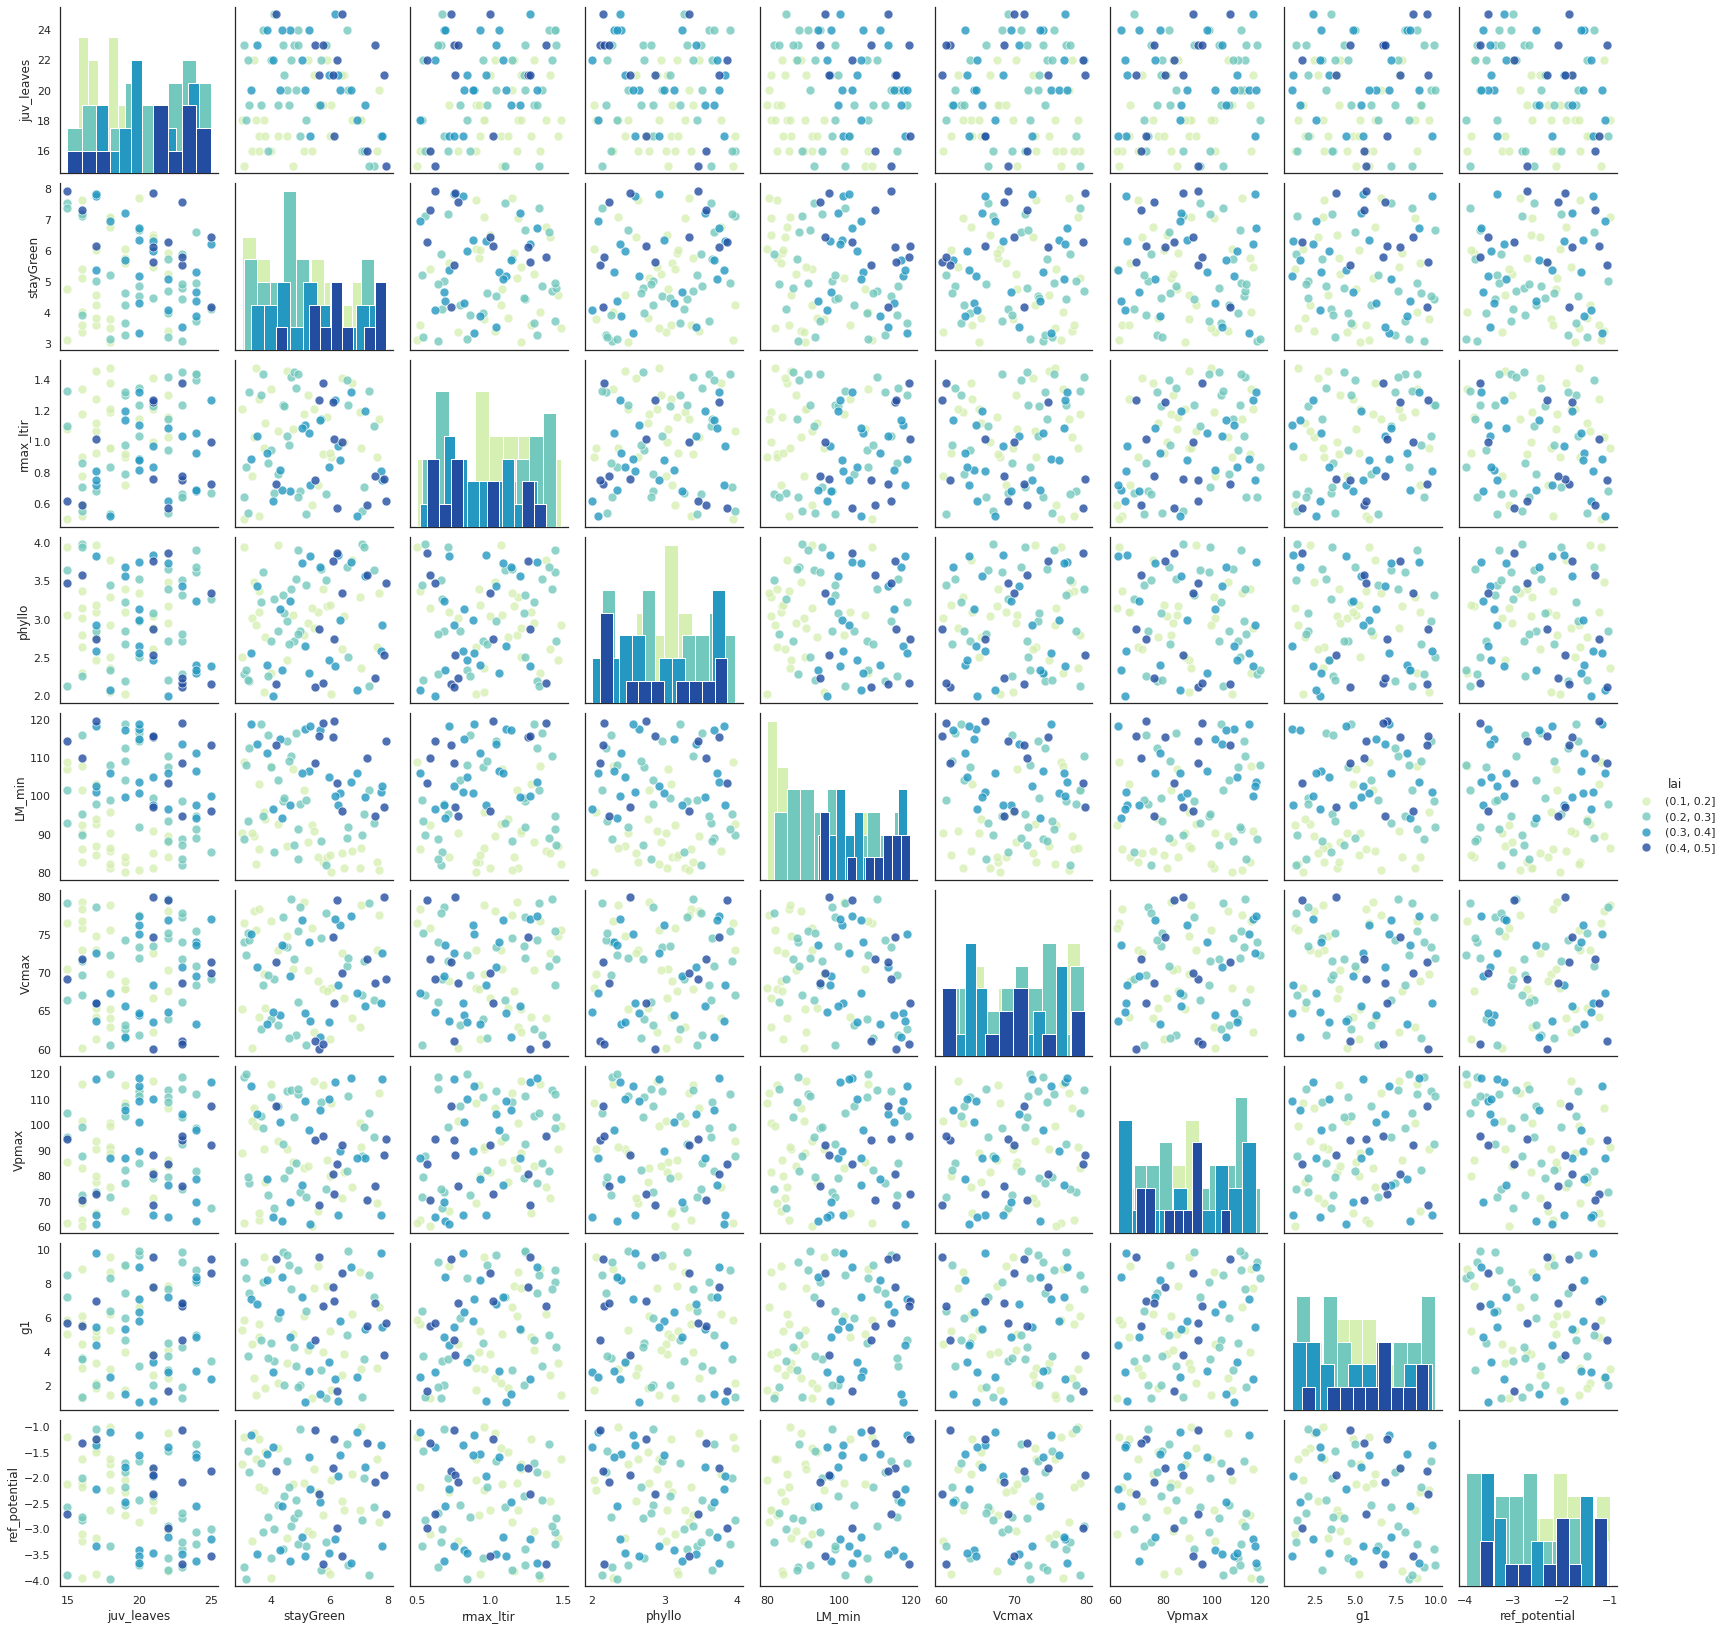

In [66]:
df_params_analyze = df_params.drop(columns=['cvar', 'ear', 'leafarea'])
sns.set_style('white')
sns.pairplot(df_params_analyze, hue='lai', palette='YlGnBu', diag_kind='hist', plot_kws=dict(alpha=0.8, s=80))

### 3. Variance decomposition

The univariate spline model (what Charlie used in his wokr) actually led to negative R2 values. <br/>
I think this means the model sucks and it does even worse than just fitting a straight line..

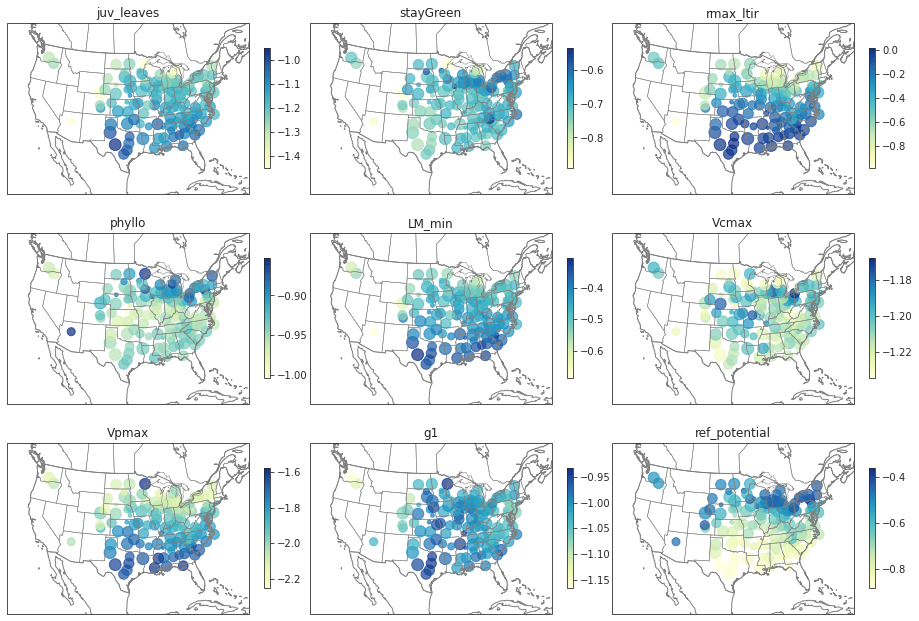

In [133]:
from palettable.colorbrewer.sequential import YlGnBu_8

df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_params['cvar'] = df_params.index

params = df_params.columns
sites = df_sites.site[:-1] # 201123: not sure why there's no simulation output for the last site
                           # going to exclude it for the moment

fig = plt.figure(figsize=(14,10))
    
for count, param in enumerate(params[:-1]):
    variances = []
    for site in sites:
        df_s = df_all[df_all.site == site]
        df_s.reset_index(inplace=True, drop=True)
        x = df_s[param]
        y = df_s.dm_ear
        mod_spline = interpolate.UnivariateSpline(x[x.argsort()], y[y.argsort()], s=1e10, k=3)
        yhat = mod_spline(x)
        x_mod = np.arange(0.5, 1.5, 0.01)
        y_mod = mod_spline(x_mod)
#        var = np.sqrt(sum((y-yhat)**2))/len(yhat)
        ssr = sum((y-yhat)**2)
        sst = sum((y-y.mean())**2)
        var = 1 - ssr/sst
        variances.append(var)

    ax = fig.add_subplot(3,3,count+1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon[:-1], df_sites.lat[:-1], s=df_sites.years[:-1]*5, 
                    c=variances, 
                    alpha=0.7, 
                    cmap=YlGnBu_8.mpl_colormap,
                    transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(str(param))
    cbar=fig.colorbar(mp, shrink=0.4)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0, hspace=-0.3)

### Goodness of fit for linear model
- R2 = 1 - SSE/SST 
    - SSE: sum of squares due to error
    - SST: total sum of squares

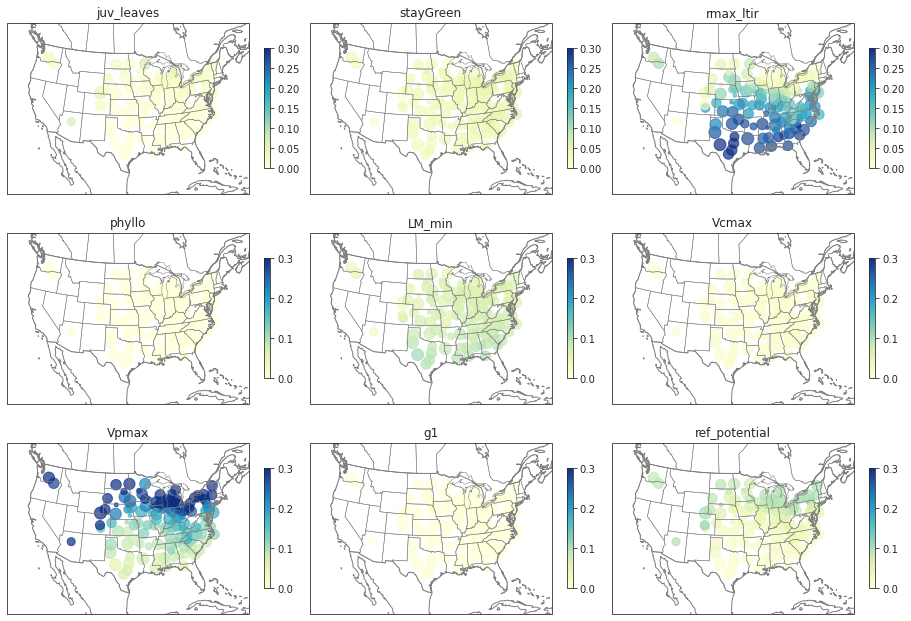

In [128]:
from palettable.colorbrewer.sequential import YlGnBu_8
import warnings
warnings.filterwarnings("ignore")

df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_params['cvar'] = df_params.index

params = df_params.columns
sites = df_sites.site[:-1] # 201123: not sure why there's no simulation output for the last site
                           # going to exclude it for the moment

fig = plt.figure(figsize=(14,10))
    
for count, param in enumerate(params[:-1]):
    variances = []
    for site in sites:
        df_s = df_all[df_all.site == site]
        df_s.reset_index(inplace=True, drop=True)
        x = df_s[param]
        y = df_s.dm_ear
        model = LinearRegression(fit_intercept=True)
        model.fit(x[:,np.newaxis],y)
        yhat = model.predict(x[:, np.newaxis])
        
#        xfit = 
#        mod_spline = interpolate.UnivariateSpline(x[x.argsort()], y[y.argsort()], s=1e10, k=3)
#        yhat = mod_spline(x)
#        x_mod = np.arange(0.5, 1.5, 0.01)
#        y_mod = mod_spline(x_mod)
#        var = np.sqrt(sum((y-yhat)**2))/len(yhat)
        ssr = sum((y-yhat)**2)
        sst = sum((y-y.mean())**2)
        var = 1 - ssr/sst
        variances.append(var)

    ax = fig.add_subplot(3,3,count+1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon[:-1], df_sites.lat[:-1], s=df_sites.years[:-1]*5, 
                    c=variances,
                    vmin=0, vmax=0.3, 
                    alpha=0.7, 
                    cmap=YlGnBu_8.mpl_colormap,
                    transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(str(param))
    cbar=fig.colorbar(mp, shrink=0.4)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0, hspace=-0.3)

### Variance decomposition with a linear model

In [82]:
import warnings
warnings.filterwarnings('ignore')

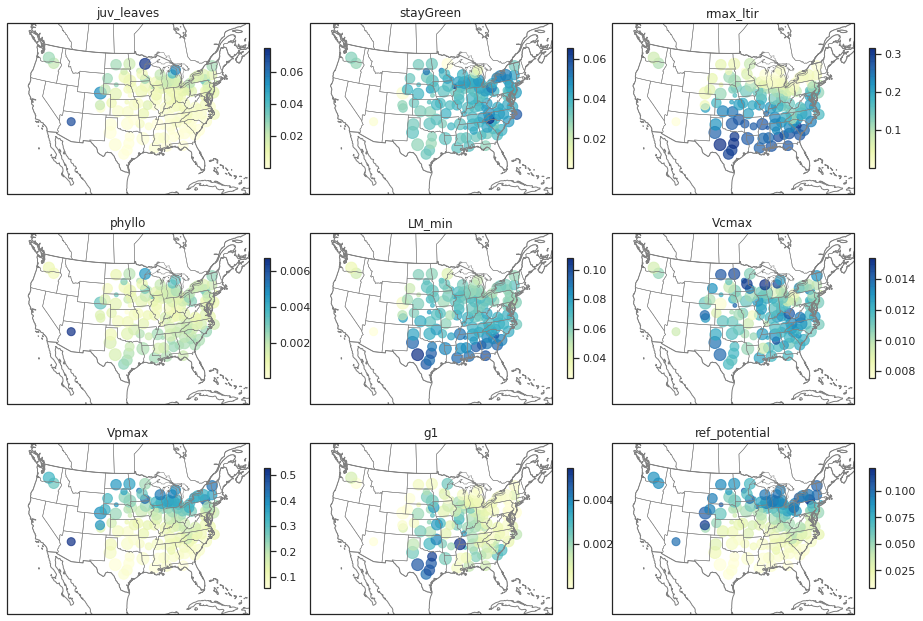

In [86]:
from palettable.colorbrewer.sequential import YlGnBu_8

params = df_params.columns
sites = df_sites.site[:-1] # 201123: not sure why there's no simulation output for the last site
                           # going to exclude it for the moment

fig = plt.figure(figsize=(14,10))
    
for count, param in enumerate(params[:-1]):
    variances = []
    for site in sites:
        df_s = df_all[df_all.site == site]
        df_s.reset_index(inplace=True, drop=True)
        x = df_s[param]
        y = df_s.dm_ear
        model = LinearRegression(fit_intercept=True)
        model.fit(x[:,np.newaxis],y)
        yhat = model.predict(x[:, np.newaxis])        
        var = yhat.var()/y.var() # equation Charlie used in his paper
        variances.append(var)

    ax = fig.add_subplot(3,3,count+1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon[:-1], df_sites.lat[:-1], s=df_sites.years[:-1]*5, 
                    c=variances, 
#                    vmin=0.1, vmax=0.3, 
                    alpha=0.7, 
                    cmap=YlGnBu_8.mpl_colormap,
                    transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(str(param))
    cbar=fig.colorbar(mp, shrink=0.4)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0, hspace=-0.3)

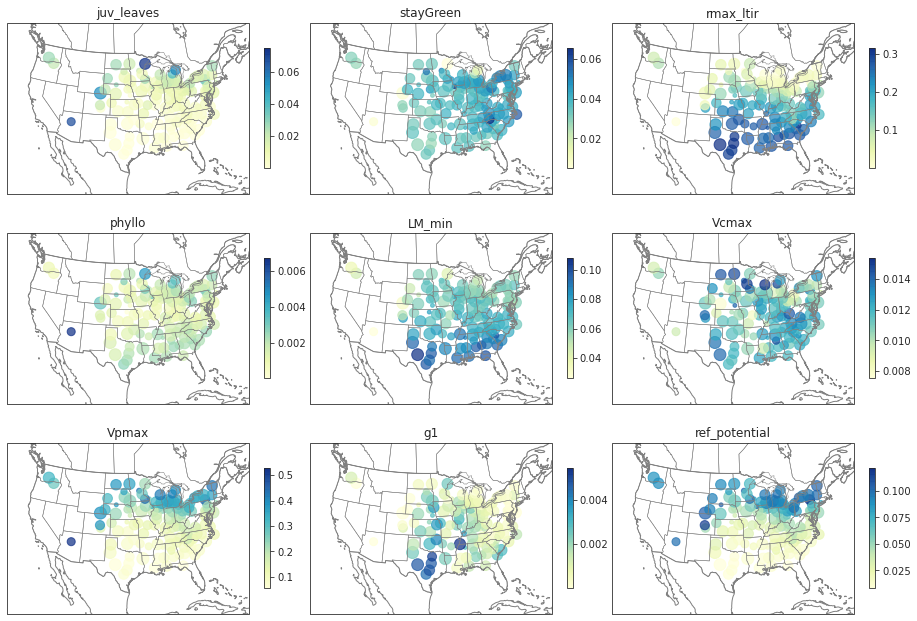

In [132]:
from palettable.colorbrewer.sequential import YlGnBu_8

params = df_params.columns
sites = df_sites.site[:-1] # 201123: not sure why there's no simulation output for the last site
                           # going to exclude it for the moment

fig = plt.figure(figsize=(14,10))
    
for count, param in enumerate(params[:-1]):
    variances = []
    for site in sites:
        df_s = df_all[df_all.site == site]
        df_s.reset_index(inplace=True, drop=True)
        x = df_s[param]
        y = df_s.dm_ear
        model = LinearRegression(fit_intercept=True)
        model.fit(x[:,np.newaxis],y)
        yhat = model.predict(x[:, np.newaxis])        
        var = yhat.var()/y.var() # equation Charlie used in his paper
        variances.append(var)

    ax = fig.add_subplot(3,3,count+1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon[:-1], df_sites.lat[:-1], s=df_sites.years[:-1]*5, 
                    c=variances, 
                    #vmin=0.3, vmax=1, 
                    alpha=0.7, 
                    cmap=YlGnBu_8.mpl_colormap,
                    transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(str(param))
    cbar=fig.colorbar(mp, shrink=0.4)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0, hspace=-0.3)

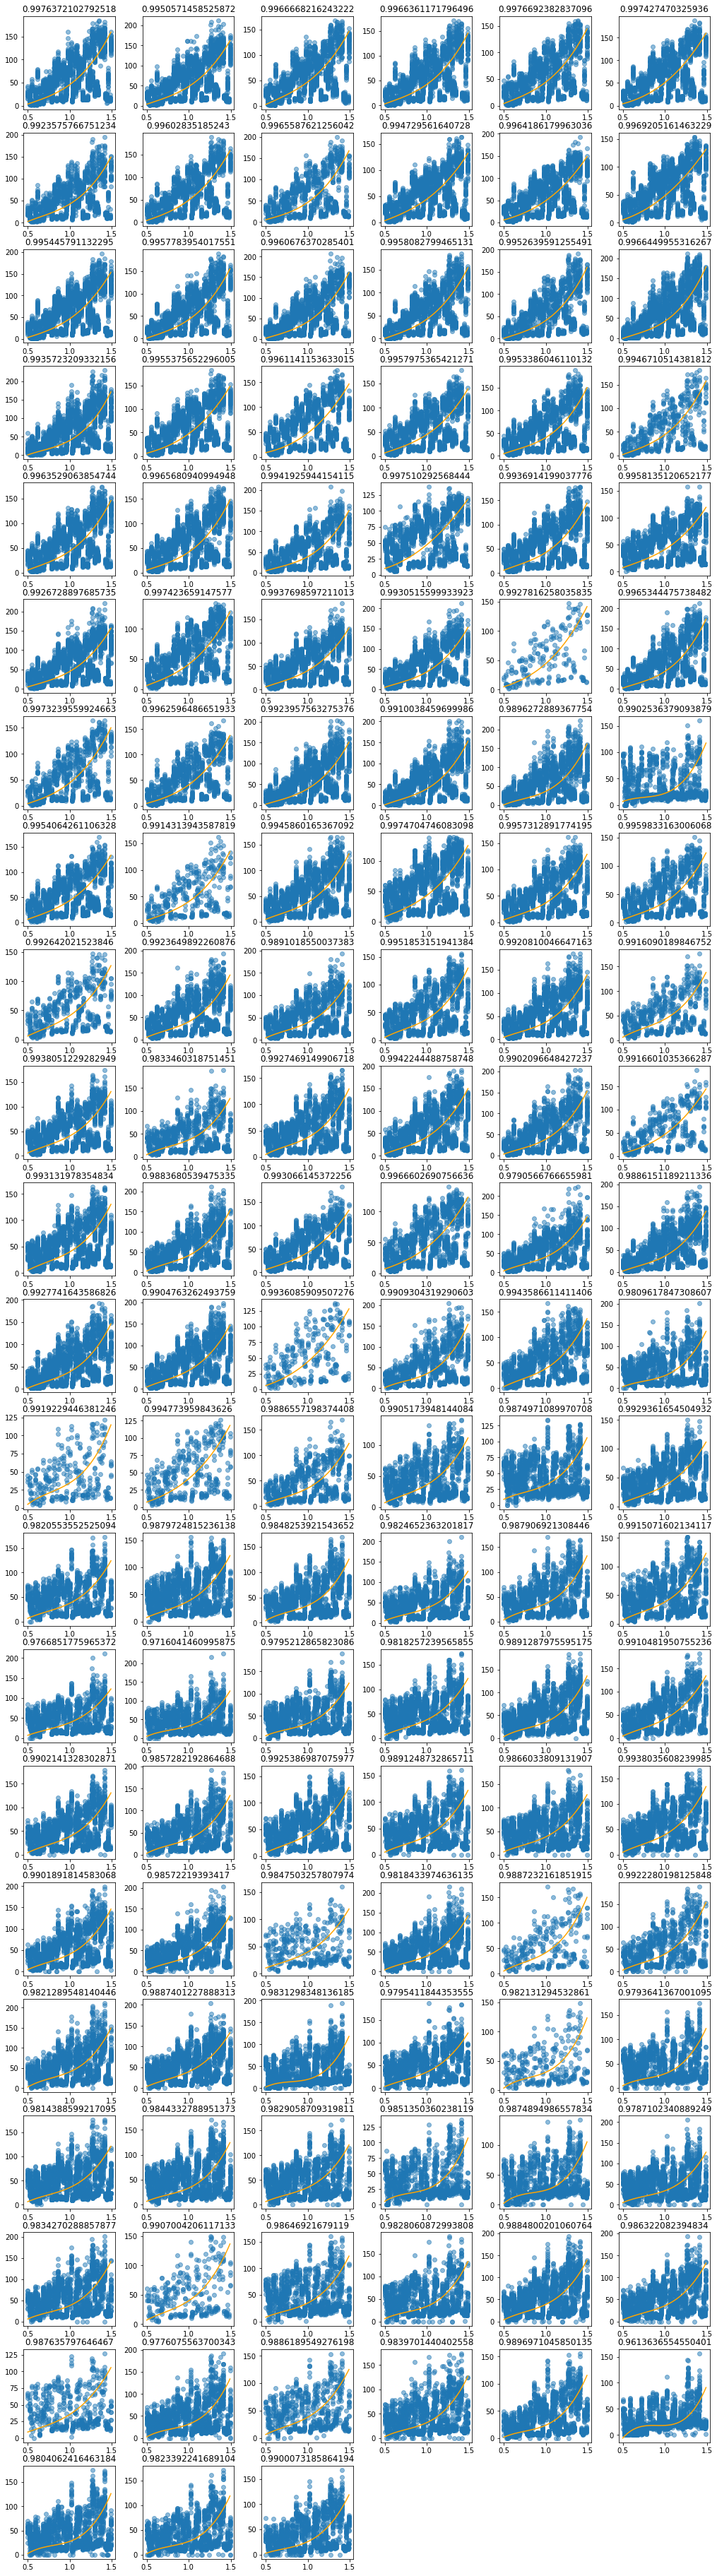

In [52]:
fig = plt.figure(figsize=(15,50))

for i, site in enumerate(sites):
    df_s = df_all[df_all.site == site]
    df_s.reset_index(inplace=True, drop=True)
    x = df_s.rmax_ltir
    y = df_s.dm_ear
    mod_spline = interpolate.UnivariateSpline(x[x.argsort()], y[y.argsort()], s=1e10, k=3)
    yhat = mod_spline(x)
    x_mod = np.arange(0.5, 1.5, 0.01)
    y_mod = mod_spline(x_mod)
#    var = round(yhat.var()/y.var(),2)
    var = (yhat-y.mean())**2/(y-y.mean())**2
    var = yhat.var()/y.var()
    ax = fig.add_subplot(22,6,i+1)
    ax.scatter(x, y, alpha=0.5)
    ax.plot(x_mod, y_mod, color='orange')
    ax.set_title(str(var))
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.3, hspace=0.25)

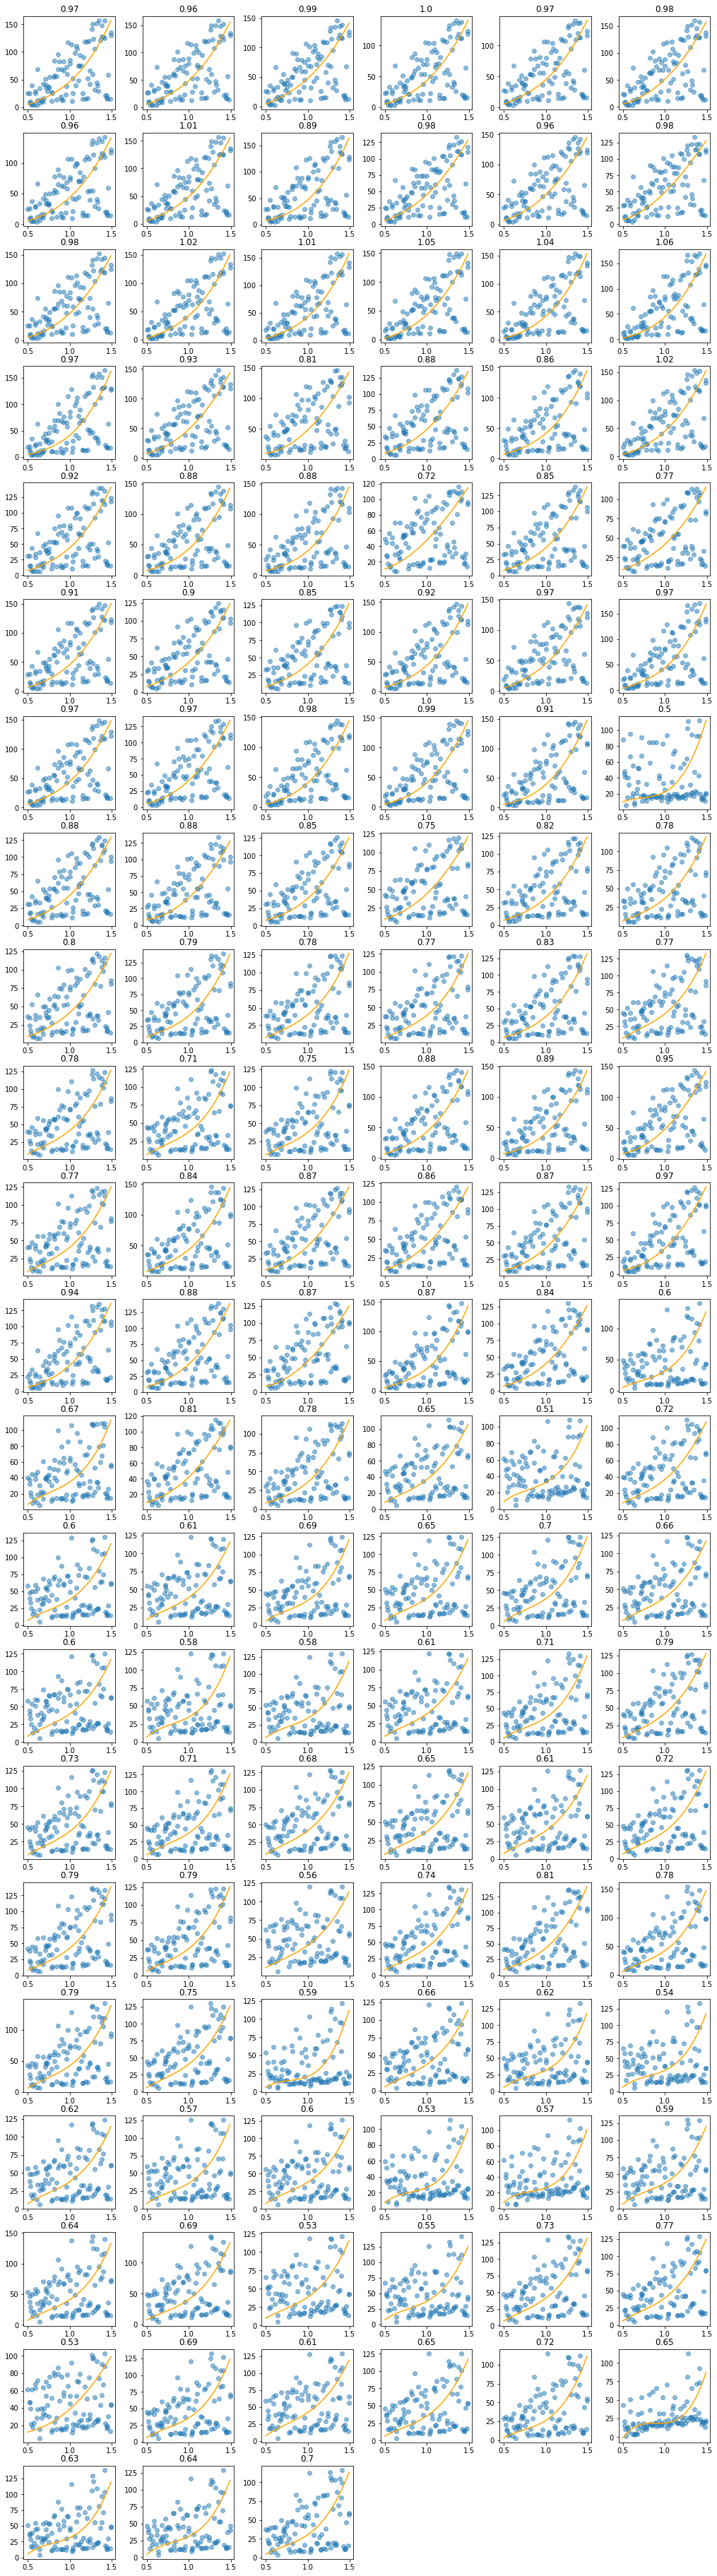

In [246]:
fig = plt.figure(figsize=(15,50))

for i, site in enumerate(sites):
    df_s = df_all[df_all.site == site]
    df_s.reset_index(inplace=True, drop=True)
    
    df_sc = df_s.groupby('cvar').mean().copy()
    x = df_sc.rmax_ltir
    y = df_sc.dm_ear
    mod_spline = interpolate.UnivariateSpline(x[x.argsort()], y[y.argsort()], s=1e10, k=3)
    yhat = mod_spline(x)
    x_mod = np.arange(0.5, 1.5, 0.01)
    y_mod = mod_spline(x_mod)
    var = round(y.var()/(y-yhat).var(),2)
#    var = round(yhat.var()/y.var(),2)
    ax = fig.add_subplot(22,6,i+1)
    ax.scatter(x, y, alpha=0.5)
    ax.plot(x_mod, y_mod, color='orange')
    ax.set_title(str(var))
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.3, hspace=0.25)